In [27]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [28]:
def calcRoundTripPnl(entryPrice, exitPrice, shares, commPct, fixedFee):
    # First: calculate the entry cost
    grossBuyValue = shares * entryPrice
    buyFee = (grossBuyValue * commPct) + fixedFee
    totalEntryCost = grossBuyValue + buyFee

    # Second: Calculate the exit revenue
    grossSellValue = shares * exitPrice
    sellFee = (grossSellValue * commPct) + fixedFee
    netExitRevenue = grossSellValue + sellFee

    #Third: Find results
    netPnlValue = netExitRevenue - totalEntryCost
    netPnlPct = (netPnlValue / totalEntryCost) *100
    totalFees = buyFee + sellFee

    return netPnlValue, netPnlPct, totalFees, netExitRevenue

In [29]:
def runBacktest(stock, monthsBack, fastSpan, slowSpan, portfolioSize,txCommPct, txFixed, spread):
    data = yf.download(stock, start=datetime.now() - relativedelta(months=monthsBack), end=datetime.now())

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    close = data['Close']
    fast = close.ewm(span=fastSpan, adjust=False).mean()
    slow = close.ewm(span=slowSpan, adjust=False).mean()

    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(data.index, close, color= 'black', alpha=0.3, label='Price') 
    ax.plot(data.index, fast, color='orange', label= f'EMA {fastSpan}')
    ax.plot(data.index, slow, color='purple', label = f'EMA {slowSpan}')

#state for backtest
    trades =[]
    cash = portfolioSize
    shares = 0
    lastBuyPrice = 0.0 #store the executed buy price for the PnL calculation

    currentState = "Below"       ####################### Talk to Daniel
    if fast.iloc[0] > slow.iloc[0]:
        currentState = "Above"

    for i in range(len(data)):
        date = data.index[i]
        price = close.iloc [i]
        fastVal = fast.iloc[i]
        slowVal = slow.iloc [i]

        if currentState == "Below" and fastVal > slowVal: ###################################### Talk to daniel
            currentState = "Above"

            #spread calc 
            execBuyPrice = price + (spread / 2)

            ### Logic for Max Shares: Cash >= (Shares * Price ) + (Shares * Price * Comm) + fixed 
            ################ is trade worth it including all trading costs
            availableCash = cash - txFixed
            if availableCash > 0:
                costPerShareEst = execBuyPrice * (1 + txCommPct)
                sharesToBuy = math.floor(availableCash / costPerShareEst)
            else:
                sharesToBuy = 0 
            if sharesToBuy > 0:
                #Find inital cost just to update cash variable. (PNL to be calculated on exit)
                grossCost = sharesToBuy * execBuyPrice
                buyFee = (grossCost * txCommPct) + txFixed
                
                cash -= (grossCost + buyFee)
                shares += sharesToBuy
                lastBuyPrice = execBuyPrice

                ax. axvline(date, color='green', linestyle= '--')

        elif currentState == "Above" and fastVal < slowVal:
            currentState = "Below"

            if shares > 0: 
                execSellPrice = price - (spread / 2)

                pnlVal, pnlPct, fees, netRevenue = calcRoundTripPnl(
                    entryPrice= lastBuyPrice,
                    exitPrice= execSellPrice,
                    shares= shares,
                    commPct=txCommPct,
                    fixedFee= txFixed
                )

                cash =+ netRevenue

                trades.append({
                    'date': date,
                    'type': 'SELL',
                    'price': execSellPrice,
                    'shares': shares,
                    'pnlVal': pnlVal,
                    'pnlPct': pnlPct,
                    'fees': fees
                })

                shares = 0
                lastBuyPrice = 0.0

            ax.axvline(date, color='red', linestyle='--')


    #Final valuation........ If holding Shares, calculate unrealised value
    finalShareValue= 0
    if shares > 0:
        execPrice = close.iloc[-1] - (spread / 2)

        pnlVal, pnlPct, fees, netRevenue = calcRoundTripPnl(
            entryPrice= lastBuyPrice,
            exitPrice= execPrice,
            shares= shares,
            commPct= txCommPct,
            fixedFee= txFixed
        )
        finalShareValue = netRevenue

    currentMarketValue = cash + finalShareValue
    percentageGl= ((currentMarketValue - portfolioSize) / portfolioSize) * 100

    ax.set_title(f'{stock} Backtest | Initial: ${portfolioSize:,.2f} | Final: ${currentMarketValue:,.2f} | G/L: {percentageGl:.2f}%)')
    ax.legend(loc='upper left')
    plt.tight_layout()

    return fig, trades, portfolioSize, currentMarketValue, percentageGl

                


[*********************100%***********************]  1 of 1 completed



====== AAPL Backtest Results ======
Market Cost (initial): $10,000.00
Market Value (final): $12,426.59
Percentage G/L: 24.27%
trades Completed: 5

--- Trade History ---
2022-12-20 | SELL | Price: $130.31 | Shares: 71 | PnL: $-697.69 (-7.00%) | Fees: $21.20
2023-09-26 | SELL | Price: $170.10 | Shares: 62 | PnL: $1,334.24 (14.47%) | Fees: $21.76
2024-02-26 | SELL | Price: $179.67 | Shares: 57 | PnL: $-285.97 (-2.71%) | Fees: $22.77
2025-03-13 | SELL | Price: $208.94 | Shares: 55 | PnL: $1,252.49 (12.22%) | Fees: $23.73
2025-07-31 | SELL | Price: $207.11 | Shares: 53 | PnL: $-345.71 (-3.05%) | Fees: $24.30


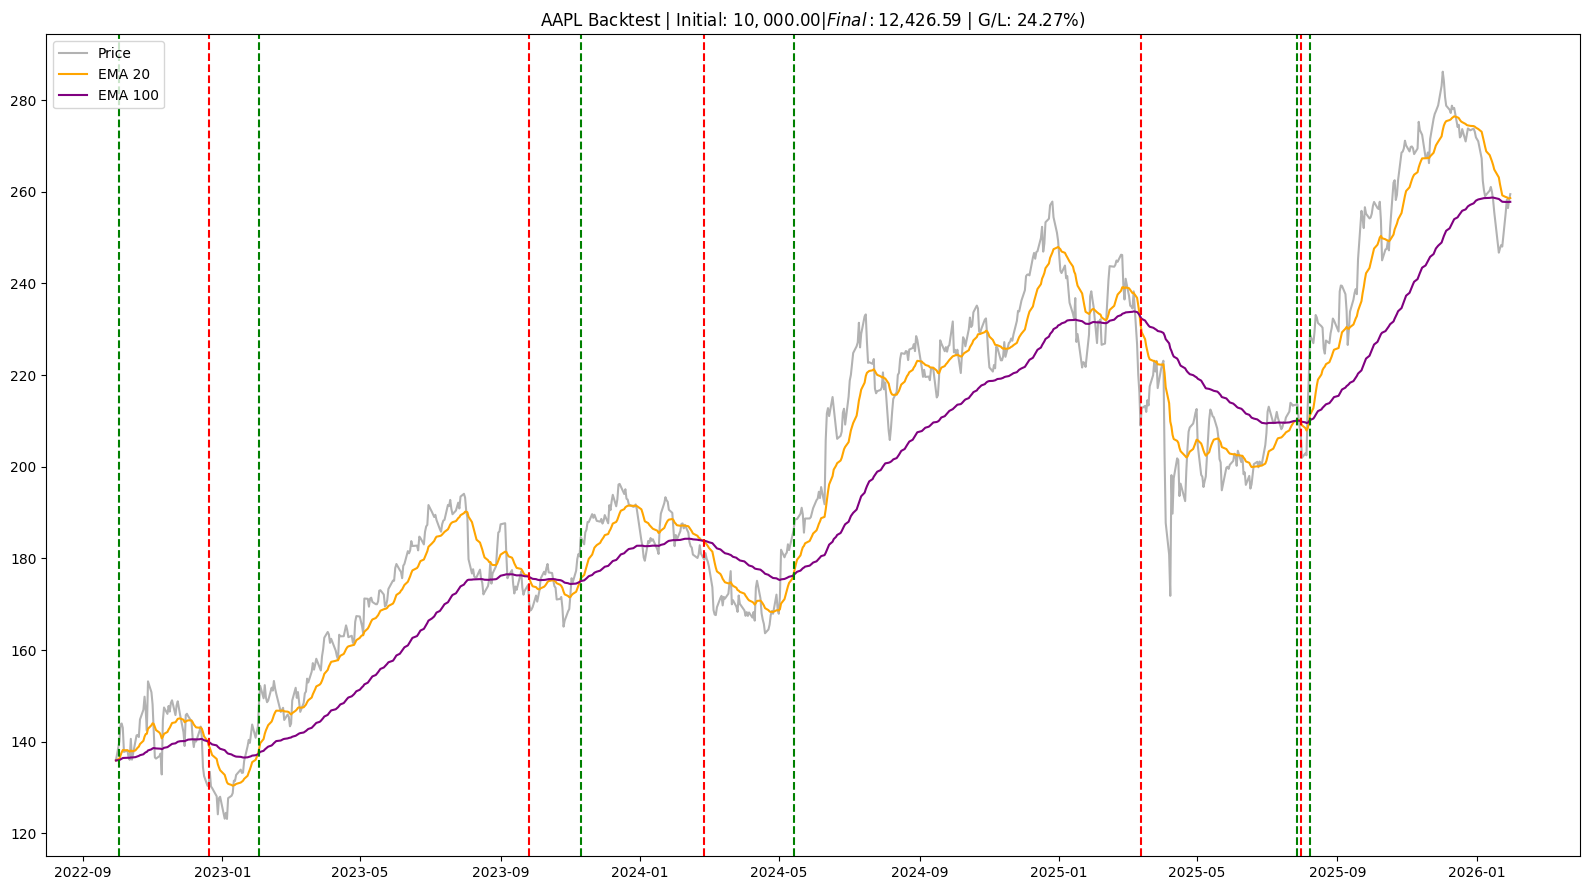

In [30]:
########### USER INPUTS ############
stock = 'AAPL'
months = 40
fast= 20
slow=100
portfolioSize= 10000

txCommPct= 0.001  #%
txFixed= 1.0  #$
spread= 0.05  #$
####################################


fig, log, cost, value, pct = runBacktest(
    stock, months, fast, slow, portfolioSize,
    txCommPct, txFixed, spread
)

print(f"\n====== {stock} Backtest Results ======")
print(f"Market Cost (initial): ${cost:,.2f}")
print(f"Market Value (final): ${value:,.2f}")
print(f"Percentage G/L: {pct:.2f}%")
print(f"trades Completed: {len(log)}")

if len(log) > 0:
    print("\n--- Trade History ---")
    for t in log:
        print(f"{t['date'].date()} | {t['type']} | Price: ${t['price']:,.2f} | Shares: {t['shares']} | PnL: ${t['pnlVal']:,.2f} ({t['pnlPct']:.2f}%) | Fees: ${t['fees']:,.2f}")

plt.show()